In [1]:
import numpy as np
import tensorflow as tf

/home/whimo/mlc/mlenv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.


(50000, 28, 28) (50000,)


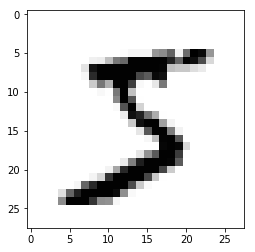

In [2]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys")

In [3]:
IMAGE_SIZE = 28
LABELS_NUM = 10

def reshape_mnist(data, labels):
    data = data.reshape((-1, IMAGE_SIZE * IMAGE_SIZE))  # Flatten images
    # One hot encode labels, e.g. transform 3 to [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    onehot_labels = (np.arange(LABELS_NUM) == labels.reshape((-1, 1)))
    return data.astype(np.float32), onehot_labels.astype(np.float32)

In [4]:
X_train, y_train = reshape_mnist(X_train, y_train)
X_val, y_val = reshape_mnist(X_val, y_val)
X_test, y_test = reshape_mnist(X_test, y_test)

In [5]:
def accuracy(predictions, labels):
    '''Simple accuracy metric'''
    return (np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) /
            predictions.shape[0]) * 100.0

## Network architecture
I use two-layer network with 50 hidden layers. The nonlinearity between these layers is a ReLU function, which is basically `max(0, x)`. Then I take the cross entropy loss and minimize it with stochastic gradient descent with batch size 128. Also, I add some L2 loss which penalizes the network for very large weights. Accuracy on the test data is usually about 97.5%.

In [6]:
BATCH_SIZE = 128
STEPS_NUM = 25001

LAYER_1_ = 50  # Hidden layer size

graph = tf.Graph()
with graph.as_default():
    '''Describe computational graph'''
    # Placeholders for dataset and labels
    # Dataset has shape (BATCH_SIZE, IMAGE_SIZE * IMAGE_SIZE),
    # because we flattened every image to a vector of shape (IMAGE_SIZE * IMAGE_SIZE, 1)
    train_data = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_SIZE * IMAGE_SIZE))
    train_labels = tf.placeholder(tf.float32, shape=(BATCH_SIZE, LABELS_NUM))

    # Validation and test datasets are constant
    val_data = tf.constant(X_val)
    val_labels = tf.constant(y_val)
    test_data = tf.constant(X_test)
    
    # Initialize weights with a truncated normal and biases with zeros
    weights_1 = tf.Variable(tf.truncated_normal([IMAGE_SIZE * IMAGE_SIZE, LAYER_1_]))
    biases_1 = tf.Variable(tf.zeros((LAYER_1_)))
    
    weights_output = tf.Variable(tf.truncated_normal([LAYER_1_, LABELS_NUM]))
    biases_output = tf.Variable(tf.zeros((LABELS_NUM)))
    
    # Training computation
    logits = tf.matmul(train_data, weights_1) + biases_1
    logits = tf.nn.relu(logits)
    logits = tf.matmul(logits, weights_output) + biases_output
    predictions = tf.nn.softmax(logits)

    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(labels=train_labels, logits=logits) +
        5e-4 * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_output)))
    # Add a bit L2 regularization here ^
    
    optimizer = tf.train.GradientDescentOptimizer(0.4).minimize(loss)
    
    # Validation and test computations
    val_logits = tf.matmul(val_data, weights_1) + biases_1
    val_logits = tf.nn.relu(val_logits)
    val_logits = tf.matmul(val_logits, weights_output) + biases_output
    val_predictions = tf.nn.softmax(val_logits)
    val_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(labels=val_labels, logits=val_logits) +
        5e-4 * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_output)))
    
    test_logits = tf.matmul(test_data, weights_1) + biases_1
    test_logits = tf.nn.relu(test_logits)
    test_logits = tf.matmul(test_logits, weights_output) + biases_output
    test_predictions = tf.nn.softmax(test_logits)

In [7]:
# tqdm is a module for rendering pretty progress bars
try:
    from tqdm import tqdm_notebook
except ModuleNotFoundError:
    def tqdm_notebook(it):
        return it

steps_log = []
val_loss_log = []
train_loss_log = []
val_accuracy_log = []
train_accuracy_log = []

def shuffle(data, labels):
    order = np.arange(data.shape[0])
    np.random.shuffle(order)
    return data[order], labels[order]

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()

    current_batches_offset = 0
    # Feed the data batch by batch
    for step in tqdm_notebook(range(STEPS_NUM)):
        offset = BATCH_SIZE * current_batches_offset
        if offset + BATCH_SIZE >= X_train.shape[0]:
            X_train, y_train = shuffle(X_train, y_train)
            # Shuffle the training dataset every time we pass through it and reset offset
            current_batches_offset = 0
            offset = 0

        # Extract batch and feed it into network
        batch_data = X_train[offset:(offset + BATCH_SIZE), :]
        batch_labels = y_train[offset:(offset + BATCH_SIZE), :]
        
        feed_dict = {train_data: batch_data, train_labels: batch_labels}
        _, loss_, predictions_ = sess.run([optimizer, loss, predictions], feed_dict=feed_dict)

        if (step % 500 == 0):
            # Evaluate accuracy every 500 steps
            train_accuracy = accuracy(predictions_, batch_labels)
            val_accuracy = accuracy(val_predictions.eval(), y_val)
            print("======== STEP {} ========".format(step))
            print("Accuracy: minibatch %.1f%%, validation %.1f%%" %
                  (train_accuracy, val_accuracy))

            steps_log.append(step)
            val_loss_log.append(val_loss.eval())
            train_loss_log.append(loss_)
            val_accuracy_log.append(train_accuracy)
            train_accuracy_log.append(val_accuracy)

        current_batches_offset += 1  # Increase offset to feed data evenly
        
    print('Test accuracy: %.2f%%' % accuracy(test_predictions.eval(), y_test))

======== STEP 0 ========
Accuracy: minibatch 11.7%, validation 19.1%
======== STEP 500 ========
Accuracy: minibatch 82.0%, validation 84.8%
======== STEP 1000 ========
Accuracy: minibatch 89.1%, validation 88.7%
======== STEP 1500 ========
Accuracy: minibatch 92.2%, validation 91.1%
======== STEP 2000 ========
Accuracy: minibatch 95.3%, validation 92.7%
======== STEP 2500 ========
Accuracy: minibatch 95.3%, validation 93.7%
======== STEP 3000 ========
Accuracy: minibatch 93.0%, validation 94.1%
======== STEP 3500 ========
Accuracy: minibatch 92.2%, validation 95.0%
======== STEP 4000 ========
Accuracy: minibatch 95.3%, validation 95.2%
======== STEP 4500 ========
Accuracy: minibatch 96.1%, validation 95.6%
======== STEP 5000 ========
Accuracy: minibatch 94.5%, validation 95.8%
======== STEP 5500 ========
Accuracy: minibatch 96.9%, validation 95.9%
======== STEP 6000 ========
Accuracy: minibatch 96.9%, validation 96.1%
======== STEP 6500 ========
Accuracy: minibatch 98.4%, validation 96

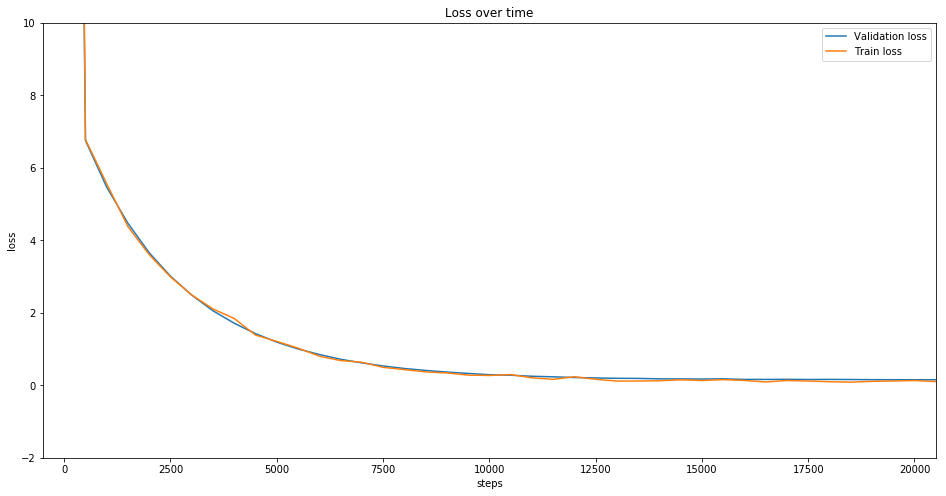

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16, 8))
plt.title('Loss over time')
plt.xlabel('steps')
plt.ylabel('loss')
val_loss_plot, = plt.plot(steps_log, val_loss_log)
train_loss_plot, = plt.plot(steps_log, train_loss_log)
plt.axis((-500, 20500, -2, 10))
plt.legend((val_loss_plot, train_loss_plot), ('Validation loss', 'Train loss'))
plt.show()

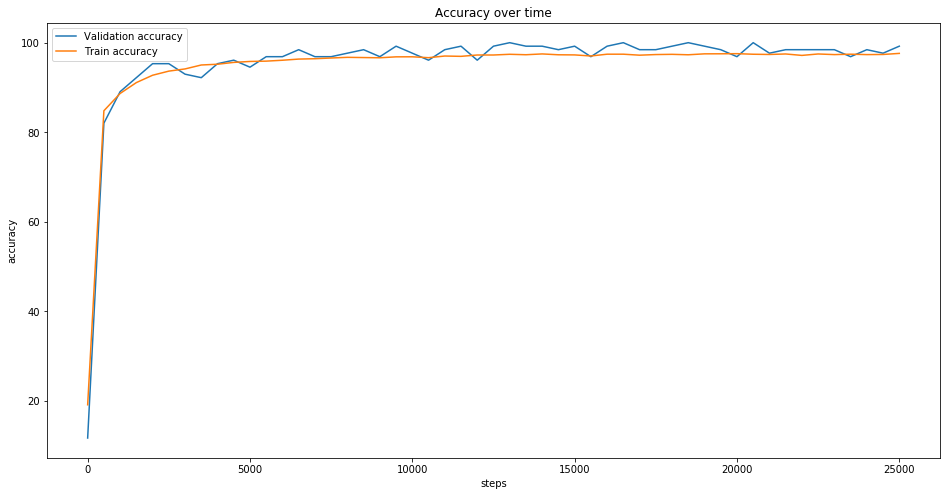

In [9]:
plt.figure(figsize=(16, 8))
plt.title('Accuracy over time')
plt.xlabel('steps')
plt.ylabel('accuracy')
val_accuracy_plot, = plt.plot(steps_log, val_accuracy_log)
train_accuracy_plot, = plt.plot(steps_log, train_accuracy_log)
plt.legend((val_accuracy_plot, train_accuracy_plot),
           ('Validation accuracy', 'Train accuracy'))
plt.show()